In [1]:
from __future__ import annotations
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import helpers

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'
table = helpers.load_seer_data(INFILE)

Basic filtering
- Beginning: 4669817 patients, 5014112 records.
- Removed 205661 patients, 235781 records where 'cancer_group' in ['Brain', 'Miscellaneous'].
- Removed 105196 patients, 113837 records where 'hist_group' in ['unspecified neoplasms'].
- Removed 0 patients, 0 records where 'diagnosis_year' not in range [2010, 2020].
- Removed 284312 patients, 589846 records with duplicated patient_id.
- Removed 0 patients, 0 records where primary cancer is marked as metastasis
- Final: 4074648 patients, 4074648 records.


In [3]:
# subset
PREDICTOR = 'predictor'
RESPONSE = 'brain_met_BOOL'

def format_lymph_cat(rec: pd.Series) -> str:
    if not rec.local_ln_met_BOOL and not rec.distant_ln_met_BOOL:
        return 'Negative'
    elif rec.local_ln_met_BOOL and not rec.distant_ln_met_BOOL:
        return 'Local'
    elif rec.distant_ln_met_BOOL:
        return 'Local+Distant'
    else:
        raise NotImplementedError

table = table.dropna(subset=['local_ln_met_BOOL', 'distant_ln_met_BOOL']).copy()
table['lymph_CAT'] = table.apply(format_lymph_cat, axis=1)


In [ ]:
# table[PREDICTOR] = table['cancer_group_CAT'] + ':' + table['hist_group_CAT'] + ':' + table['lymph_CAT']
MIN_CASES = 20
table[PREDICTOR] = table['cancer_group_CAT'] + ':' + table['hist_group_CAT']
counts = table[table[RESPONSE]==True].groupby(PREDICTOR)['lymph_CAT'].value_counts().unstack().fillna(0).astype(int)
counts = counts[['Negative', 'Local', 'Local+Distant']]
counts['valid'] = (counts > MIN_CASES).all(axis=1)
counts = counts.sort_values(by=['valid', 'Negative', 'Local', 'Local+Distant'], ascending=False)
print(counts.shape)
print(counts.head(20))

valid = set(counts[counts['valid']==True].index.to_list())
table = table[table[PREDICTOR].isin(valid)]
print()
print(table[PREDICTOR].value_counts())


(12, 4)
lymph_CAT                                             Negative  Local  Local+Distant  valid
predictor                                                                                  
Lung and Bronchus:adenomas and adenocarcinomas            2238   5722           1311   True
Lung and Bronchus:epithelial neoplasms                    1007   3134            847   True
Kidney and Renal Pelvis:adenomas and adenocarcinomas       437    130            219   True
Lung and Bronchus:squamous cell neoplasms                  432    982            152   True
Skin:nevi and melanomas                                    378    157            163   True
Breast:ductal and lobular neoplasms                        140    370            325   True
Colorectal:adenomas and adenocarcinomas                     98     60             50   True
Pancreas:adenomas and adenocarcinomas                       53     24             31   True
Esophagus:adenomas and adenocarcinomas                      45    102   

In [ ]:
pframe = pd.DataFrame(index=sorted(list(table[PREDICTOR].unique())))
for value in ['Negative', 'Local', 'Local+Distant']:
    df = table[table['lymph_CAT']==value].copy()
    prev = helpers.prevalence(df, PREDICTOR, RESPONSE)
    pframe[value] = prev['stat']
    # print()
    # print(f"lymph_CAT='{value}'")
    # print(pframe)
    # print(df.groupby(PREDICTOR)[RESPONSE].value_counts().unstack().fillna(0).astype(int))
pframe



,Negative,Local,Local+Distant
Breast:ductal and lobular neoplasms,0.059,0.488,8.767
Breast:epithelial neoplasms,1.077,3.266,14.683
Colorectal:adenomas and adenocarcinomas,0.131,0.176,1.850
Esophagus:adenomas and adenocarcinomas,1.072,2.818,5.518
Kidney and Renal Pelvis:adenomas and adenocarcinomas,0.868,5.546,12.860
Lung and Bronchus:adenomas and adenocarcinomas,6.448,19.910,29.388
Lung and Bronchus:epithelial neoplasms,10.992,16.345,25.390
Lung and Bronchus:squamous cell neoplasms,2.544,6.723,13.333
Pancreas:adenomas and adenocarcinomas,0.248,0.390,2.429
Prostate:adenomas and adenocarcinomas,0.023,0.278,1.357


In [68]:
tframe = pd.DataFrame(index=sorted(list(table[PREDICTOR].unique())))
cframe = pd.DataFrame(index=sorted(list(table[PREDICTOR].unique())))

ln_steps = ['Negative', 'Local', 'Local+Distant']
tstage_dframes = {}
for value in ln_steps:
    df = table[(table['any_met_BOOL']==True) & (table['lymph_CAT']==value)].copy()
    # brain tendency (preference)
    prev = helpers.prevalence(df, PREDICTOR, RESPONSE)
    tframe[value] = prev['stat']
    # brain met counts
    counts = df.groupby(PREDICTOR)[RESPONSE].value_counts().unstack().fillna(0)
    counts.columns = [str(x) for x in counts.columns]
    cframe[value] = counts['True']
    # brain met == True; T-stage counts
    tstage_df = df[df['brain_met_BOOL']==True].groupby(PREDICTOR)['TSTAGE_CAT'].value_counts().unstack().fillna(0).astype(int)
    tstage_dframes[value] = tstage_df.sort_index()

tframe = tframe.sort_index()

print(tframe)
print()
print(cframe)


                                                      Negative  Local  Local+Distant
Breast:ductal and lobular neoplasms                      5.812  5.940         11.226
Breast:epithelial neoplasms                              9.127 11.184         17.290
Colorectal:adenomas and adenocarcinomas                  1.286  0.733          2.299
Esophagus:adenomas and adenocarcinomas                   6.818  8.279          7.875
Kidney and Renal Pelvis:adenomas and adenocarcinomas    11.885  8.990         14.619
Lung and Bronchus:adenomas and adenocarcinomas          31.218 37.308         36.276
Lung and Bronchus:epithelial neoplasms                  33.803 29.290         30.348
Lung and Bronchus:squamous cell neoplasms               21.774 23.331         20.568
Pancreas:adenomas and adenocarcinomas                    0.555  0.980          2.900
Prostate:adenomas and adenocarcinomas                    0.672  0.887          1.841
Skin:nevi and melanomas                                 39.958 29

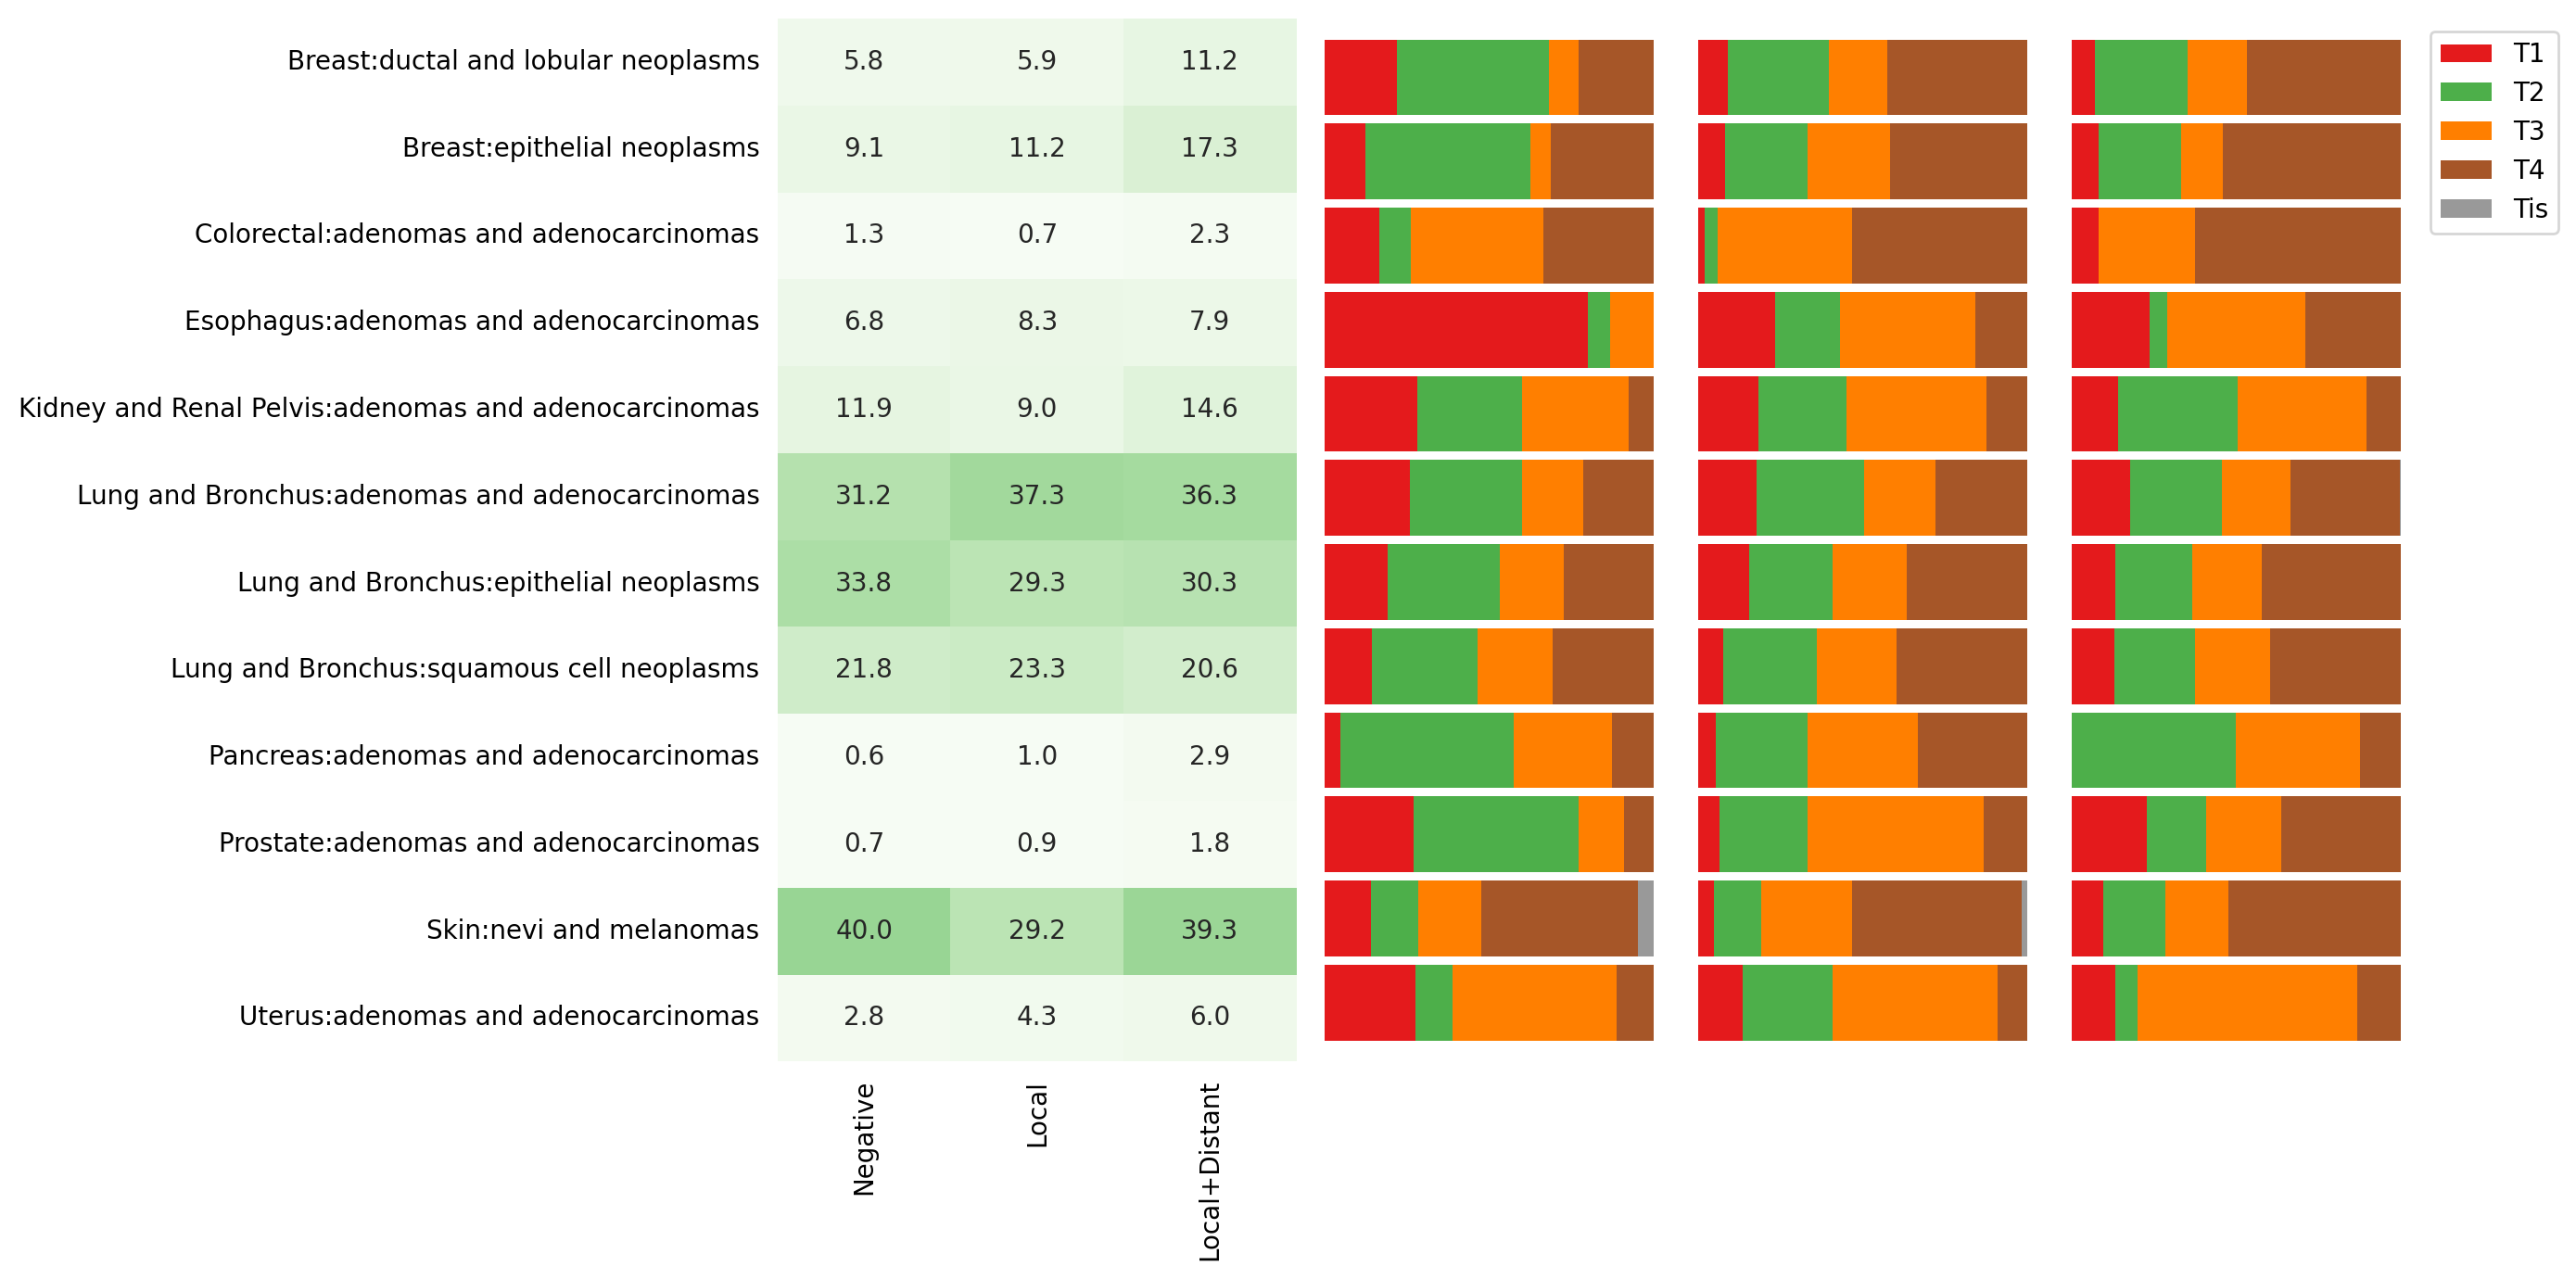

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=4, width_ratios=(1.5, 1, 1, 1), figsize=(14, 7), dpi=200)
sns.heatmap(tframe, square=False, annot=True, fmt='.1f', cmap='Greens', vmax=100, vmin=0, ax=axes[0], cbar=False)
axes[0].tick_params(axis='y', left=False)
axes[0].tick_params(axis='x', bottom=False, rotation=90)
# ax.tick_params(axis='x', rotation=90)

ln_steps = ['Negative', 'Local', 'Local+Distant']
for i, ln_level in enumerate(ln_steps):
    ax = axes[i+1]
    df = tstage_dframes[ln_level]
    row_sums = df.sum(axis=1)
    df_norm = df.div(row_sums, axis=0)
    df_norm = df_norm.sort_index(ascending=False)
    if i == len(ln_steps) - 1:
        df_norm.plot.barh(stacked=True, cmap='Set1', width=0.9, legend=True, ax=ax)
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    else:
        df_norm.plot.barh(stacked=True, cmap='Set1', width=0.9, legend=False, ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()